In [272]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
import sys
import os

In [273]:
# Función para gráficar histogramas de variables numéricas (hecho con ayuda de deepseek r1)
def plot_numeric_analysis(df, numeric_cols, figsize=(15, 10)):
    """Gráfica histogramas de variables numéricas, adaptando los ejes a la data."""
    if not numeric_cols:
        print("No hay columnas numéricas para graficar.")
        return

    n_cols = min(3, len(numeric_cols))
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

    if len(numeric_cols) <= 2:
        figsize = (8, 5)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.suptitle('Análisis de Variables Numéricas', fontsize=16)

    # Aplanar los ejes para simplificar la iteración
    axes = np.array(axes).flatten() if isinstance(axes, np.ndarray) else np.array([axes])

    for idx, col in enumerate(numeric_cols):
        # Se extrae la data de la columna ignorando valores nulos
        data = df[col].dropna()
        # Se calcula un margen del 5% del rango para que el gráfico no esté muy pegado a los bordes
        if not data.empty:
            margin = 0.05 * (data.max() - data.min())
            x_min = data.min() - margin
            x_max = data.max() + margin
        else:
            x_min, x_max = 0, 1

        # Graficamos el histograma usando bins automáticos para mejor adaptación
        sns.histplot(data=df, x=col, ax=axes[idx], bins='auto')
        axes[idx].set_title(f'Distribución de {col}')
        axes[idx].set_xlim(x_min, x_max)

    # Ocultar subplots no utilizados
    for idx in range(len(numeric_cols), len(axes)):
        axes[idx].set_visible(False)

    # Ajustamos el layout dejando espacio para el título general
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Función para detectar outlayers con el método IQR, extremos y no extremos
def iqr_method(column):
    """Detecta outliers usando el método IQR."""
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    extreme_lower_bound = q1 - 3 * iqr
    extreme_upper_bound = q3 + 3 * iqr
    return pd.Series([column>upper_bound, column<lower_bound, column>extreme_upper_bound, column<extreme_lower_bound], 
                     index=['outliers_upper', 'outliers_lower', 'extreme_upper', 'extreme_lower'])

# Función para realizar un análisis exploratorio de una tabla (mejorado con ayuda de claude 3.7 sonnet)
def analisis_exploratorio(name, df):
    """Realiza un análisis exploratorio de una tabla."""
    total_chars = 125
    print("="*total_chars)
    string = f"Análisis de la tabla {name}"
    print('|' + string.center(total_chars-2) + '|')
    print("="*total_chars)
    print(f"Dimensiones: {df.shape}")
    
    # Expresión regular para identificar columnas ID
    id_pattern = re.compile(
        r'^id_.*|.*_id$|^id$',  # Empieza con id_, termina con _id, o es exactamente id
        flags=re.IGNORECASE
    )
    id_cols = [col for col in df.columns if id_pattern.fullmatch(col)]
    
    # Separar columnas numéricas y no numéricas
    numeric_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in id_cols]
    non_numeric_cols = list(df.select_dtypes(exclude=['int64', 'float64']).columns)
    
    # Normalizar strings y manejar IDs
    for col in non_numeric_cols:
        if pd.api.types.is_string_dtype(df[col]):
            df[col] = df[col].apply(lambda x: x.lower().strip() if pd.notna(x) else x)
    
    # Agregar IDs a no numéricas para estadísticas especiales
    non_numeric_cols += id_cols

    non_numeric_stats = []
    if non_numeric_cols:
        for col in non_numeric_cols:
            stats = {
                'Columna': col,
                'Valores Únicos': df[col].nunique(),
                'Media': '-',
                'Desviación Estándar': '-',
                'Mínimo': df[col].min() if col in id_cols else '-',
                'Mediana': '-',
                'Máximo': df[col].max() if col in id_cols else '-'
            }
            non_numeric_stats.append(stats)
    
    numeric_stats = []
    cols_to_remove = []
    if numeric_cols:
        for col in numeric_cols:
            if df[col].nunique() == 2 and set(df[col].dropna().unique()).issubset({0, 1}):
                df[col] = df[col].astype('boolean')
                cols_to_remove.append(col)
            else:
                numeric_stats.append({
                    'Columna': col,
                    'Valores Únicos': df[col].nunique(),
                    'Media': df[col].mean(),
                    'Desviación Estándar': df[col].std(),
                    'Mínimo': df[col].min(),
                    'Mediana': df[col].median(),
                    'Máximo': df[col].max()
                })
        # Remover columnas convertidas a boolean
        numeric_cols = [col for col in numeric_cols if col not in cols_to_remove]
    
    # Crear un único DataFrame con todas las estadísticas
    all_stats = []
    
    for col in df.columns:
        is_numeric = col in numeric_cols
        
        stats = {
            'Columna': col,
            'Valores Únicos': df[col].nunique(),
            'Media': df[col].mean() if is_numeric else '-',
            'Desviación Estándar': df[col].std() if is_numeric else '-',
            'Mínimo': df[col].min() if is_numeric or col in id_cols else '-',
            'Mediana': df[col].median() if is_numeric else '-',
            'Máximo': df[col].max() if is_numeric or col in id_cols else '-',
            'Tipos de datos': df[col].apply(type).unique() if len(df[col].apply(type).unique()) == 1 else '\n'.join(str(t) for t in df[col].apply(type).unique()),
            'NaN/Null': df[col].isnull().sum(),
            'Duplicados únicos': len(df[(df.duplicated(subset=[col], keep='first'))&(df[col].notnull())]),
            'Duplicados totales': len(df[(df.duplicated(subset=[col], keep=False))&(df[col].notnull())])
        }
        
        # Agregar información de outliers solo para columnas numéricas
        if is_numeric:
            iqr_stats = iqr_method(df[col])
            stats.update({
                'Outlayers (IQR extreme_lower)': iqr_stats['extreme_lower'].sum(),
                'Outlayers (IQR lower)': iqr_stats['outliers_lower'].sum(),
                'Outlayers (IQR upper)': iqr_stats['outliers_upper'].sum(),
                'Outlayers (IQR extreme_upper)': iqr_stats['extreme_upper'].sum()
            })
        else:
            stats.update({
                'Outlayers (IQR extreme_lower)': '-',
                'Outlayers (IQR lower)': '-',
                'Outlayers (IQR upper)': '-',
                'Outlayers (IQR extreme_upper)': '-'
            })
            
        all_stats.append(stats)
    
    # Crear un único DataFrame con todas las estadísticas
    all_stats_df = pd.DataFrame(all_stats).set_index('Columna')
    inconsistencias_stats_df = all_stats_df.T
    
    print('\nEstadísticas descriptivas y problemas de calidad:')
    print(inconsistencias_stats_df.to_markdown(index=True))
    
    if numeric_cols:
        plot_numeric_analysis(df, numeric_cols)
    return

In [274]:
source_file = '../data/raw/Airbnb_Data.csv'
df = pd.read_csv(source_file, low_memory=False)

|                                              Análisis de la tabla airbnb_data                                             |
Dimensiones: (74111, 29)

Estadísticas descriptivas y problemas de calidad:
|                               | id              | log_price          | property_type   | room_type       | amenities       | accommodates       | bathrooms          | bed_type        | cancellation_policy   | cleaning_fee     | city            | description     | first_review    | host_has_profile_pic   | host_identity_verified   | host_response_rate   | host_since      | instant_bookable   | last_review     | latitude           | longitude           | name            | neighbourhood   | number_of_reviews   | review_scores_rating   | thumbnail_url   | zipcode         | bedrooms          | beds               |
|:------------------------------|:----------------|:-------------------|:----------------|:----------------|:----------------|:-------------------|:-------------------|:----------

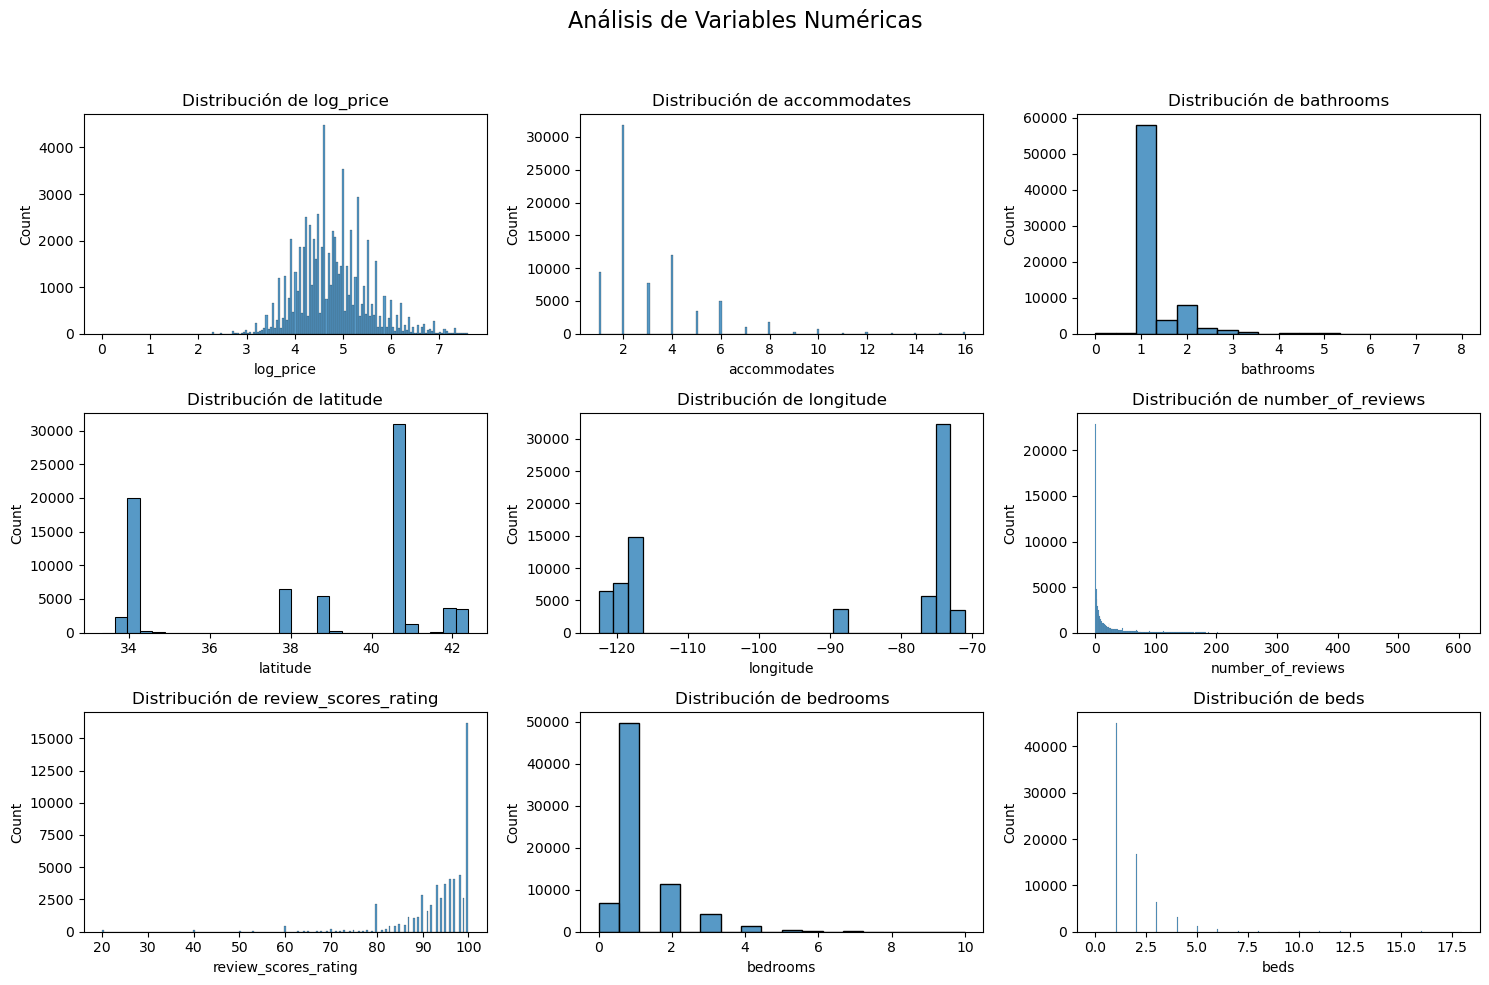

In [275]:
analisis_exploratorio('airbnb_data', df)

Para ahorrar tiempo podemos omitir la limpieza de columnas que no sean valiosas y en cambio limpiar columnas que describen directamente las características físicas de la propiedad (`property_type`, `room_type`, `accommodates`, `bathrooms`, `bedrooms`, `beds`), la ubicación (`city`, `neighbourhood), y factores de calidad (`amenities`, `review_scores_rating`, `number_of_reviews`, `cleaning_fee`, `bed_type`). También son relevantes las políticas de reserva (`cancellation_policy`, `instant_bookable`) y atributos del anfitrión (`host_identity_verified`, `host_response_rate`, `host_since`, `host_has_profile_pic`). En contraste, columnas como `id`, `name`, `description`, `thumbnail_url`, `first_review` y `last_review` aportan poco valor predictivo por ser identificadores únicos o texto no estructurado por lo que podemos omitirlas para el modelo. La columna `log_price` sería la variable objetivo.

Con ello vamos a conservar y limpiar las columnas: `log_price`, `property_type`, `room_type`, `accommodates`, `bathrooms`, `bedrooms`, `beds`, `city`, `neighbourhood`, `amenities`, `review_scores_rating`, `number_of_reviews`, `cleaning_fee`, `bed_type`, `cancellation_policy`, `instant_bookable`, `host_identity_verified`, `host_response_rate`, `host_since` y `host_has_profile_pic`.

In [276]:
df_filtered = df[[
    'log_price','property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 
    'city', 'neighbourhood', 'amenities', 
    'review_scores_rating', 'number_of_reviews', 'cleaning_fee', 'bed_type', 
    'cancellation_policy', 'instant_bookable', 'host_identity_verified', 
    'host_response_rate', 'host_since', 'host_has_profile_pic'
]].copy()

del df 

|                                         Análisis de la tabla airbnb_data_filtered                                         |
Dimensiones: (74111, 20)

Estadísticas descriptivas y problemas de calidad:
|                               | log_price          | property_type   | room_type       | accommodates       | bathrooms          | bedrooms          | beds               | city            | neighbourhood   | amenities       | review_scores_rating   | number_of_reviews   | cleaning_fee     | bed_type        | cancellation_policy   | instant_bookable   | host_identity_verified   | host_response_rate   | host_since      | host_has_profile_pic   |
|:------------------------------|:-------------------|:----------------|:----------------|:-------------------|:-------------------|:------------------|:-------------------|:----------------|:----------------|:----------------|:-----------------------|:--------------------|:-----------------|:----------------|:----------------------|:------------

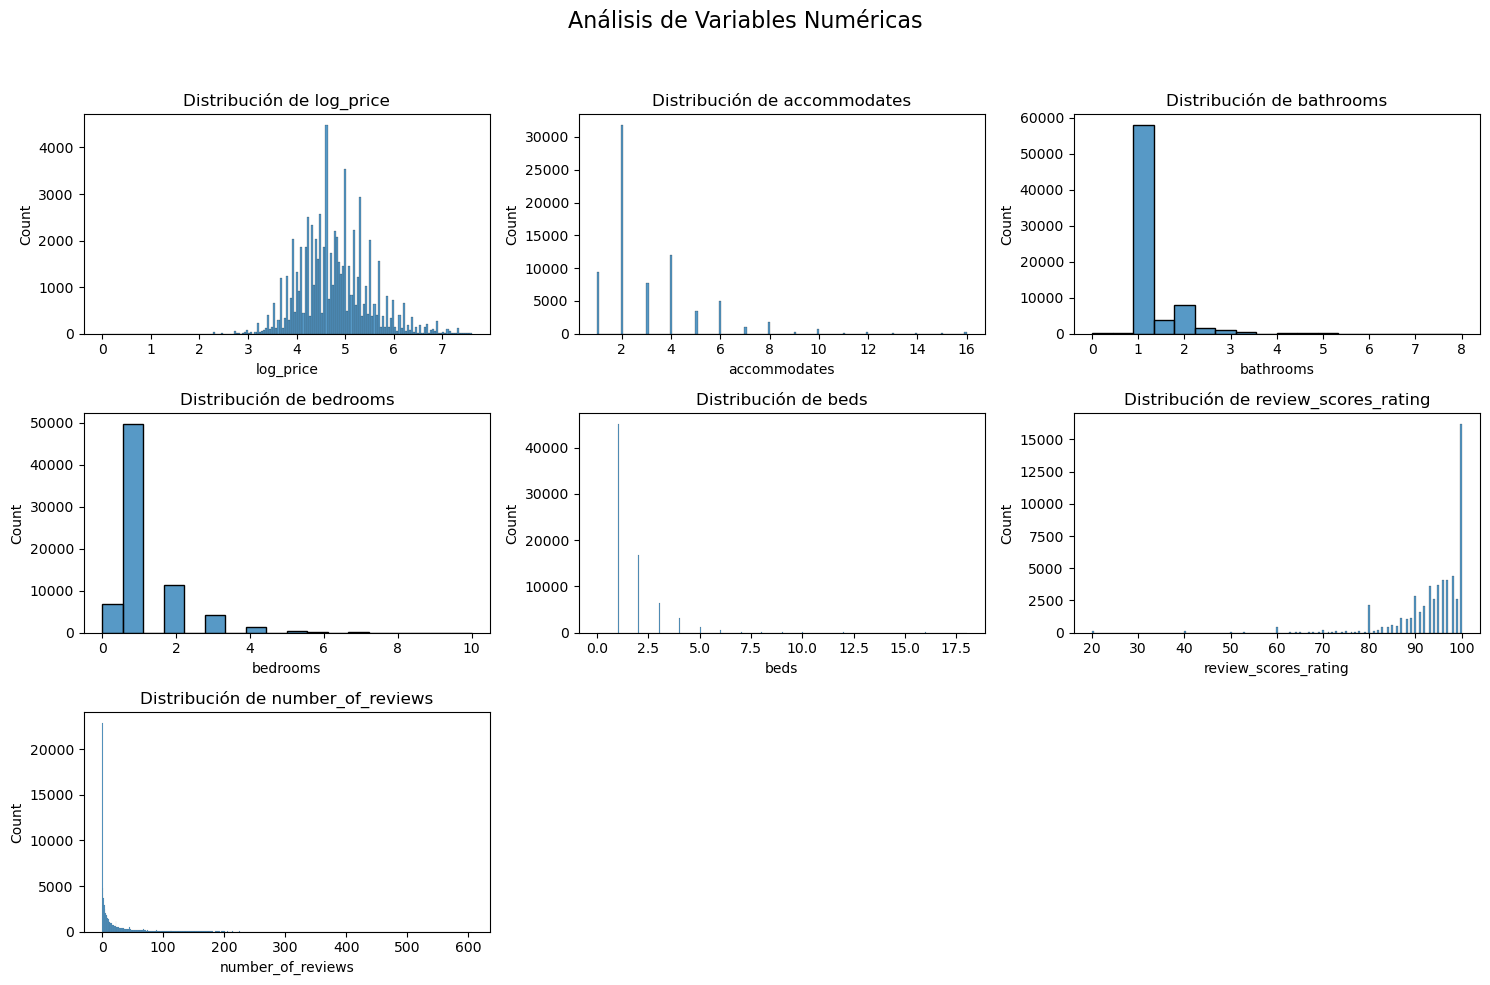

In [277]:
analisis_exploratorio('airbnb_data_filtered', df_filtered)

Para la columna `neighbourhood` se puede imputar los valores nulos con **"Desconocido"** para mantener la coherencia en los datos y evitar la pérdida de información.

In [278]:
# Fill string columns as mentioned in cell 7
df_filtered['neighbourhood'] = df_filtered['neighbourhood'].fillna('Desconocido')

In [279]:
print("Valores únicos para 'accommodates':")
print(df_filtered['accommodates'].unique())

print("Valores únicos para 'bathrooms':")
print(df_filtered['bathrooms'].unique())

print("\nValores únicos para 'bedrooms':")
print(df_filtered['bedrooms'].unique())

print("\nValores únicos para 'beds':")
print(df_filtered['beds'].unique())

Valores únicos para 'accommodates':
[ 3  7  5  4  2  6  8  1  9 10 16 11 12 14 13 15]
Valores únicos para 'bathrooms':
[1.  1.5 2.  nan 2.5 3.  0.5 4.5 5.  0.  4.  3.5 5.5 7.5 6.  8.  7.  6.5]

Valores únicos para 'bedrooms':
[ 1.  3.  2.  0.  4. nan  5.  6.  7.  8.  9. 10.]

Valores únicos para 'beds':
[ 1.  3.  2.  7.  4.  6.  5. nan 10.  8. 16.  9. 13. 12. 11. 14. 15.  0.
 18.]


Ya que `bathrooms`presenta valores decimales cuando debería de ser una columna solo con valores enteros se procedera a redondear los números decimales.

In [280]:
df_filtered[df_filtered['beds'] == 0]

,log_price,property_type,room_type,accommodates,bathrooms,bedrooms,beds,city,neighbourhood,amenities,review_scores_rating,number_of_reviews,cleaning_fee,bed_type,cancellation_policy,instant_bookable,host_identity_verified,host_response_rate,host_since,host_has_profile_pic
13672,5.129899,apartment,entire home/apt,2,1.0,1.0,0.0,sf,Cow Hollow,"{tv,internet,""wireless internet"",kitchen,washe...",NaN,0,True,real bed,strict,f,t,NaN,2011-08-31,t
24062,5.783825,house,entire home/apt,2,1.0,0.0,0.0,nyc,Midtown East,"{tv,internet,""wireless internet"",""air conditio...",NaN,0,False,real bed,super_strict_30,t,t,100%,2016-08-30,t
39057,4.691348,apartment,entire home/apt,2,1.0,0.0,0.0,boston,Back Bay,"{tv,""cable tv"",internet,""wireless internet"",""a...",94.0,53,True,real bed,strict,t,t,100%,2014-02-14,t
55285,5.991465,house,entire home/apt,4,1.0,1.0,0.0,nyc,Midtown East,"{tv,internet,""wireless internet"",""air conditio...",NaN,0,False,real bed,super_strict_30,t,t,100%,2016-08-30,t


Ya que un Airbnb que tenga 0 camas no es lógico y son pocos registros podemos quitarlos 

In [281]:
# Drop records where beds = 0 as they're not logical for Airbnb listings
print(f"Records removed: {len(df_filtered[df_filtered['beds'] == 0])}")
df_filtered = df_filtered[df_filtered['beds'] != 0]
print(f"Records remaining: {len(df_filtered)}")

Records removed: 4
Records remaining: 74107


In [282]:
df_filtered['bathrooms'] = df_filtered['bathrooms'].round()

Ahora analizaremos `host_response_rate`

In [283]:
df_filtered['host_response_rate']

0         NaN
1        100%
2        100%
3         NaN
4        100%
         ... 
74106     NaN
74107    100%
74108    100%
74109    100%
74110    100%
Name: host_response_rate, Length: 74107, dtype: object

`host_response_rate` se tiene que transformar a float 

In [284]:
df_filtered['host_response_rate'] = df_filtered['host_response_rate'].str.replace('%', '').astype(float)

<Axes: title={'center': 'Distribución de host_response_rate'}, ylabel='Frequency'>

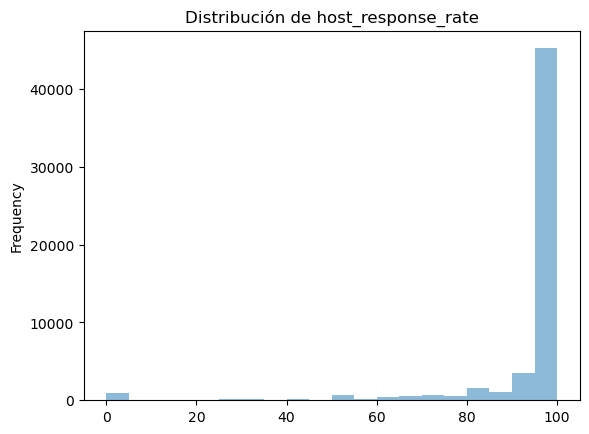

In [285]:
df_filtered['host_response_rate'].plot.hist(bins=20, alpha=0.5, title='Distribución de host_response_rate')

In [286]:
outliers_result = iqr_method(df_filtered['host_response_rate'])

# Create masks for different outlier types
upper_outliers = outliers_result['outliers_upper']
extreme_upper = outliers_result['extreme_upper']
lower_outliers = outliers_result['outliers_lower']
extreme_lower = outliers_result['extreme_lower']

print(f"Media de host_response_rate: {df_filtered['host_response_rate'].mean()}")
print(f"Upper outliers: {upper_outliers.sum()}")
print(f"Extreme upper outliers: {extreme_upper.sum()}")
print(f"Lower outliers: {lower_outliers.sum()}")
print(f"Extreme lower outliers: {extreme_lower.sum()}")

df_filtered[lower_outliers]

Media de host_response_rate: 94.35166371015427
Upper outliers: 0
Extreme upper outliers: 0
Lower outliers: 12558
Extreme lower outliers: 12558


,log_price,property_type,room_type,accommodates,bathrooms,bedrooms,beds,city,neighbourhood,amenities,review_scores_rating,number_of_reviews,cleaning_fee,bed_type,cancellation_policy,instant_bookable,host_identity_verified,host_response_rate,host_since,host_has_profile_pic
18,4.882802,apartment,entire home/apt,2,1.0,1.0,2.0,nyc,Lower East Side,"{tv,""cable tv"",internet,""wireless internet"",""a...",86.0,26,True,real bed,strict,f,t,71.0,2015-08-17,t
29,4.653960,apartment,private room,3,1.0,1.0,2.0,nyc,Murray Hill,"{tv,internet,""wireless internet"",""air conditio...",88.0,40,True,real bed,strict,f,f,68.0,2016-03-06,t
30,4.317488,apartment,private room,2,1.0,1.0,1.0,nyc,Lefferts Garden,"{tv,""cable tv"",internet,""wireless internet"",""a...",100.0,1,True,real bed,strict,f,t,67.0,2014-01-06,t
31,3.828641,apartment,private room,2,1.0,1.0,1.0,la,Mid-Wilshire,"{""wireless internet"",""air conditioning"",kitche...",NaN,0,True,real bed,strict,f,f,83.0,2017-03-18,t
34,4.356709,apartment,entire home/apt,4,1.0,1.0,2.0,la,Desconocido,"{tv,internet,""wireless internet"",""air conditio...",NaN,1,True,real bed,flexible,t,f,50.0,2016-10-24,t
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74088,4.905275,house,entire home/apt,5,2.0,2.0,2.0,dc,Desconocido,"{tv,internet,""wireless internet"",""air conditio...",90.0,3,False,real bed,flexible,f,t,90.0,2013-07-07,t
74089,4.605170,house,private room,2,1.0,1.0,1.0,la,Altadena,"{tv,""cable tv"",internet,""air conditioning"",poo...",NaN,0,True,real bed,strict,f,f,0.0,2014-04-14,t
74091,5.010635,apartment,entire home/apt,2,1.0,0.0,1.0,nyc,East Village,"{""wireless internet"",""air conditioning"",kitche...",100.0,5,False,real bed,moderate,f,t,70.0,2014-10-23,t
74092,4.700480,apartment,entire home/apt,4,2.0,2.0,3.0,chicago,Old Town,"{tv,""cable tv"",internet,""wireless internet"",""a...",96.0,15,True,real bed,strict,t,t,90.0,2014-01-16,t


Debido a que la distribución de `host_response_rate` está centrada alrededor de su media del 94%, los outliers detectados por el método IQR lower parecen normales, por lo que no es necesario realizar ninguna acción.

In [287]:
df_filtered[df_filtered['host_response_rate'].isnull()]

,log_price,property_type,room_type,accommodates,bathrooms,bedrooms,beds,city,neighbourhood,amenities,review_scores_rating,number_of_reviews,cleaning_fee,bed_type,cancellation_policy,instant_bookable,host_identity_verified,host_response_rate,host_since,host_has_profile_pic
0,5.010635,apartment,entire home/apt,3,1.0,1.0,1.0,nyc,Brooklyn Heights,"{""wireless internet"",""air conditioning"",kitche...",100.0,2,True,real bed,strict,f,t,NaN,2012-03-26,t
3,6.620073,house,entire home/apt,4,1.0,2.0,2.0,sf,Lower Haight,"{tv,""cable tv"",internet,""wireless internet"",ki...",NaN,0,True,real bed,flexible,f,t,NaN,2015-04-19,t
12,4.248495,apartment,private room,2,1.0,1.0,1.0,la,Torrance,"{tv,internet,""wireless internet"",kitchen,""free...",NaN,0,True,real bed,flexible,f,f,NaN,2016-05-10,t
16,4.317488,loft,private room,2,1.0,1.0,1.0,chicago,Wicker Park,"{tv,""wireless internet"",kitchen,""pets allowed""...",91.0,15,False,real bed,strict,f,f,NaN,2016-07-29,t
23,4.007333,house,private room,2,1.0,1.0,1.0,la,Valley Glen,"{internet,""wireless internet"",""air conditionin...",100.0,2,True,real bed,moderate,f,t,NaN,2012-07-12,t
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74083,5.010635,apartment,private room,2,1.0,1.0,1.0,sf,Russian Hill,"{tv,""wireless internet"",kitchen,""smoke detecto...",NaN,0,False,real bed,flexible,f,t,NaN,2013-01-08,t
74085,4.653960,apartment,entire home/apt,2,1.0,1.0,1.0,dc,Kalorama,"{tv,""cable tv"",internet,""wireless internet"",""a...",87.0,3,False,real bed,flexible,f,t,NaN,2013-04-10,t
74095,4.382027,apartment,entire home/apt,2,1.0,1.0,1.0,nyc,Bay Ridge,"{tv,""cable tv"",internet,""wireless internet"",""a...",NaN,0,False,real bed,flexible,f,t,NaN,2014-04-23,t
74096,3.912023,apartment,private room,2,1.0,1.0,1.0,nyc,Washington Heights,"{tv,""cable tv"",internet,""wireless internet"",""a...",60.0,2,False,real bed,flexible,f,f,NaN,2012-08-11,t


Ya que no hay un patrón aparente en los valores nulos se trata de un caso MCAR y podriamos imputar esos datos con la media 

En cuanto a las columnas `accommodates, bathrooms, bedrooms, beds`se van a analizar incositencias físicas y outliers

In [288]:
outliers_result = iqr_method(df_filtered['accommodates'])

upper_outliers = outliers_result['outliers_upper']
extreme_upper = outliers_result['extreme_upper']

df_filtered[upper_outliers].sort_values('accommodates', ascending=False).sort_values(['bathrooms', 'bedrooms', 'beds'], ascending=True)

,log_price,property_type,room_type,accommodates,bathrooms,bedrooms,beds,city,neighbourhood,amenities,review_scores_rating,number_of_reviews,cleaning_fee,bed_type,cancellation_policy,instant_bookable,host_identity_verified,host_response_rate,host_since,host_has_profile_pic
46602,7.313220,other,entire home/apt,16,0.0,0.0,1.0,chicago,Logan Square,"{internet,""wireless internet"",""air conditionin...",NaN,0,True,real bed,strict,f,t,95.0,2016-10-20,t
46923,6.396930,townhouse,private room,16,0.0,0.0,1.0,nyc,Crown Heights,"{""wireless internet"",""air conditioning"",""wheel...",NaN,0,True,real bed,strict,f,f,100.0,2017-04-12,t
4428,4.521789,house,entire home/apt,16,0.0,0.0,1.0,la,Desconocido,"{internet,""wireless internet"",""wheelchair acce...",100.0,5,True,real bed,moderate,t,t,97.0,2015-12-05,t
9941,6.028279,other,entire home/apt,16,0.0,0.0,1.0,la,Desconocido,"{internet,""wireless internet"",""air conditionin...",NaN,0,True,real bed,moderate,t,t,NaN,2017-04-17,t
31439,6.907755,earth house,entire home/apt,10,0.0,0.0,1.0,la,Desconocido,"{""free parking on premises"",""pets allowed"",""fa...",NaN,0,False,couch,flexible,f,t,NaN,2015-11-19,t
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17806,6.856462,apartment,entire home/apt,16,8.0,10.0,16.0,la,Desconocido,"{tv,internet,""wireless internet"",""air conditio...",NaN,0,True,real bed,strict,f,t,88.0,2015-11-24,t
33031,5.293305,apartment,entire home/apt,8,NaN,2.0,NaN,la,Palms,"{tv,""cable tv"",internet,""wireless internet"",""a...",NaN,0,True,real bed,strict,f,t,95.0,2012-09-05,t
45453,6.309918,house,entire home/apt,8,NaN,3.0,4.0,la,Venice,"{tv,""cable tv"",""wireless internet"",""air condit...",NaN,0,True,real bed,strict,f,t,97.0,2011-09-28,t
64536,7.090077,house,entire home/apt,8,NaN,4.0,5.0,la,Sunland/Tujunga,"{tv,""cable tv"",internet,""wireless internet"",""a...",96.0,18,True,real bed,strict,f,t,93.0,2012-08-10,t


Analizando los outlayers en `accommodates` se encontraron incositencias físicas ya que en algunos registros, el número de personas que se pueden alojar es extremadamente alto en comparación con la cantidad de camas y habitaciones disponibles. Por ejemplo, hay casos donde se reporta que el alojamiento puede recibir 16 huéspedes, pero solo cuenta con 0 o 1 cama, lo mismo para el el número de habitaciones o baños, lo cual no es realista desde un punto de vista físico.

In [289]:
# Count the inconsistent entries before filtering
outliers = df_filtered[upper_outliers]
print(f"Total upper outliers: {len(outliers)}")

# Identificar entradas inconsistentes donde el número de camas es menor que la mitad del número de accommodates
inconsistent_entries = outliers[outliers['accommodates'] // 2 > outliers['beds']]
inconsistent_count = len(inconsistent_entries)
print(f"Inconsistent entries: {inconsistent_count}")

Total upper outliers: 3604
Inconsistent entries: 982


In [290]:
df_filtered[extreme_upper].sort_values('accommodates', ascending=False).sort_values(['bathrooms', 'bedrooms', 'beds'], ascending=True)

,log_price,property_type,room_type,accommodates,bathrooms,bedrooms,beds,city,neighbourhood,amenities,review_scores_rating,number_of_reviews,cleaning_fee,bed_type,cancellation_policy,instant_bookable,host_identity_verified,host_response_rate,host_since,host_has_profile_pic
4428,4.521789,house,entire home/apt,16,0.0,0.0,1.0,la,Desconocido,"{internet,""wireless internet"",""wheelchair acce...",100.0,5,True,real bed,moderate,t,t,97.0,2015-12-05,t
9941,6.028279,other,entire home/apt,16,0.0,0.0,1.0,la,Desconocido,"{internet,""wireless internet"",""air conditionin...",NaN,0,True,real bed,moderate,t,t,NaN,2017-04-17,t
46923,6.396930,townhouse,private room,16,0.0,0.0,1.0,nyc,Crown Heights,"{""wireless internet"",""air conditioning"",""wheel...",NaN,0,True,real bed,strict,f,f,100.0,2017-04-12,t
46602,7.313220,other,entire home/apt,16,0.0,0.0,1.0,chicago,Logan Square,"{internet,""wireless internet"",""air conditionin...",NaN,0,True,real bed,strict,f,t,95.0,2016-10-20,t
52055,5.521461,apartment,entire home/apt,16,0.0,0.0,NaN,sf,Russian Hill,"{tv,""cable tv"",""wireless internet"",kitchen,""ca...",NaN,0,False,real bed,flexible,f,f,100.0,2012-10-28,t
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3063,7.598399,villa,entire home/apt,16,8.0,8.0,11.0,la,Topanga,"{tv,""cable tv"",internet,""wireless internet"",""a...",NaN,0,True,real bed,strict,f,t,100.0,2012-09-28,t
54697,7.495542,house,entire home/apt,16,8.0,10.0,16.0,nyc,Flushing,"{tv,""cable tv"",""wireless internet"",""air condit...",NaN,0,True,real bed,flexible,f,f,100.0,2017-06-28,t
17806,6.856462,apartment,entire home/apt,16,8.0,10.0,16.0,la,Desconocido,"{tv,internet,""wireless internet"",""air conditio...",NaN,0,True,real bed,strict,f,t,88.0,2015-11-24,t
19213,6.684612,house,entire home/apt,16,8.0,10.0,16.0,la,Desconocido,"{tv,""cable tv"",internet,""wireless internet"",""a...",NaN,0,True,real bed,strict,f,t,100.0,2012-08-06,t


In [291]:
# Count the inconsistent entries before filtering
outliers = df_filtered[extreme_upper]
print(f"Total extreme outliers: {len(outliers)}")

# Identificar entradas inconsistentes donde el número de camas es menor que la mitad del número de accommodates
inconsistent_entries = outliers[outliers['accommodates'] // 2 > outliers['beds']]
inconsistent_count = len(inconsistent_entries)
print(f"Inconsistent entries: {inconsistent_count}")

Total extreme outliers: 838
Inconsistent entries: 315


Podemos observar que de todos los outliers upper de `accommodates`hay una porción que es incosistente físicamente es decir que no tiene el número de camas necesarias para alojar el número de personas. Se van a eliminar estos registros ya que son outlaiers inconsistentes.

En cuanto a los upper outaliers de las columnas `bathrooms, bedrooms, beds`se los conservaran pues no son valores muy altos y son consistentes con el número de `accommodates`

In [292]:
df_filtered[df_filtered['bathrooms'] == 0].sort_values('accommodates', ascending=False)

,log_price,property_type,room_type,accommodates,bathrooms,bedrooms,beds,city,neighbourhood,amenities,review_scores_rating,number_of_reviews,cleaning_fee,bed_type,cancellation_policy,instant_bookable,host_identity_verified,host_response_rate,host_since,host_has_profile_pic
9941,6.028279,other,entire home/apt,16,0.0,0.0,1.0,la,Desconocido,"{internet,""wireless internet"",""air conditionin...",NaN,0,True,real bed,moderate,t,t,NaN,2017-04-17,t
64556,5.703782,house,private room,16,0.0,1.0,1.0,nyc,Bushwick,"{tv,""cable tv"",internet,""wireless internet"",""a...",72.0,5,True,real bed,moderate,f,t,89.0,2014-06-01,t
4428,4.521789,house,entire home/apt,16,0.0,0.0,1.0,la,Desconocido,"{internet,""wireless internet"",""wheelchair acce...",100.0,5,True,real bed,moderate,t,t,97.0,2015-12-05,t
53730,3.891820,dorm,shared room,16,0.0,1.0,16.0,la,Venice,"{tv,internet,""wireless internet"",kitchen,break...",73.0,35,False,real bed,strict,f,t,90.0,2011-10-06,t
52055,5.521461,apartment,entire home/apt,16,0.0,0.0,NaN,sf,Russian Hill,"{tv,""cable tv"",""wireless internet"",kitchen,""ca...",NaN,0,False,real bed,flexible,f,f,100.0,2012-10-28,t
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69672,4.060443,house,private room,1,0.0,1.0,1.0,sf,Balboa Terrace,"{tv,internet,""wireless internet"",""free parking...",94.0,13,True,real bed,strict,t,f,100.0,2016-07-26,t
73077,4.077537,apartment,private room,1,0.0,1.0,1.0,boston,Roslindale,"{tv,internet,""wireless internet"",""air conditio...",96.0,80,False,real bed,strict,f,t,100.0,2011-09-18,t
73301,3.218876,bed & breakfast,shared room,1,0.0,1.0,1.0,la,Desconocido,"{""translation missing: en.hosting_amenity_49"",...",NaN,0,False,real bed,strict,f,f,100.0,2017-03-31,t
73467,4.369448,apartment,private room,1,0.0,1.0,1.0,nyc,Greenpoint,"{tv,""cable tv"",internet,""wireless internet"",""a...",97.0,18,False,real bed,moderate,f,f,100.0,2012-01-22,t


Hay 407 registros con cero `bathrooms`(que serian sus lower outliers), como no se trata de muchos registros y sería ilogico que un lugar no tenga baño se podría imputar con 1 baño o 1 baño por cada 5 personas

In [293]:
zero_bedrooms = df_filtered[df_filtered['bedrooms'] == 0]
property_type_counts = zero_bedrooms['property_type'].value_counts()

total_zero_bedrooms = len(zero_bedrooms)
total_properties = len(df_filtered)
print(f"\nTotal properties with 0 bedrooms: {total_zero_bedrooms} ({total_zero_bedrooms/total_properties:.2%} of all properties)")

print("Count of properties with 0 bedrooms by property type:")
print(property_type_counts)


Total properties with 0 bedrooms: 6713 (9.06% of all properties)
Count of properties with 0 bedrooms by property type:
property_type
apartment             5276
house                  508
guesthouse             180
loft                   178
condominium            143
other                  109
bungalow                93
townhouse               40
guest suite             25
camper/rv               25
cabin                   23
timeshare               21
in-law                  21
boutique hotel          20
bed & breakfast         13
boat                     9
hostel                   6
dorm                     3
serviced apartment       3
vacation home            3
yurt                     3
hut                      3
tent                     2
tipi                     1
casa particular          1
earth house              1
castle                   1
cave                     1
villa                    1
Name: count, dtype: int64


Dado que las propiedades con 0 dormitorios representan un 9.06% del total, no se considera adecuado imputar valores, ya que esto podría introducir sesgos en el análisis. Además, muchos de estos tipos de propiedades, como *lofts, estudios, bungalows o alojamientos únicos* (ej. *tipis, cuevas, casas en árboles*), pueden legítimamente no contar con dormitorios separados. Por ello, se opta por conservar los datos tal como están, respetando la diversidad de las propiedades registradas en la plataforma.

También en estas columnas podemos analizar incosistencias físicas y filtrarlas también

In [294]:
inconsistent_filter = (
    (df_filtered['accommodates'] >= 8) & 
    (df_filtered['bathrooms'] <= 1) & 
    (df_filtered['bedrooms'] <= 1) & 
    (df_filtered['beds'] <= 1)
)

extreme_inconsistency = df_filtered[inconsistent_filter]
extreme_inconsistency

,log_price,property_type,room_type,accommodates,bathrooms,bedrooms,beds,city,neighbourhood,amenities,review_scores_rating,number_of_reviews,cleaning_fee,bed_type,cancellation_policy,instant_bookable,host_identity_verified,host_response_rate,host_since,host_has_profile_pic
569,7.130899,loft,private room,16,1.0,0.0,1.0,la,Downtown,"{tv,""wireless internet"",""air conditioning"",""sm...",NaN,0,False,real bed,flexible,t,t,90.0,2016-09-25,t
768,6.802395,loft,entire home/apt,12,1.0,1.0,1.0,sf,SoMa,"{tv,internet,""wireless internet"",""air conditio...",99.0,118,True,couch,strict,f,t,100.0,2012-07-20,t
1998,5.433722,loft,entire home/apt,16,1.0,0.0,1.0,la,Sun Valley,"{tv,internet,""wireless internet"",""air conditio...",NaN,0,False,real bed,moderate,t,t,82.0,2014-04-09,t
2105,6.396930,other,entire home/apt,16,1.0,0.0,1.0,nyc,Williamsburg,"{internet,""wireless internet"",""air conditionin...",100.0,4,True,real bed,strict,f,t,100.0,2013-03-10,t
2294,7.090077,other,entire home/apt,16,1.0,0.0,1.0,sf,Bernal Heights,"{tv,""wireless internet"",kitchen,""pets allowed""...",100.0,2,True,real bed,strict,f,f,100.0,2015-11-04,t
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66374,6.745236,townhouse,entire home/apt,8,1.0,0.0,1.0,nyc,Harlem,"{tv,""cable tv"",internet,""wireless internet"",""a...",NaN,0,True,real bed,flexible,f,f,100.0,2013-07-31,t
66456,4.060443,apartment,entire home/apt,10,1.0,1.0,1.0,chicago,Little Village,"{tv,internet,""wireless internet"",""air conditio...",91.0,97,True,real bed,moderate,f,t,92.0,2015-08-13,t
67718,5.991465,loft,entire home/apt,16,1.0,1.0,1.0,nyc,Chinatown,"{tv,""cable tv"",internet,""wireless internet"",""a...",95.0,16,True,real bed,strict,f,t,90.0,2016-06-06,t
71983,6.300786,other,shared room,16,1.0,1.0,1.0,la,Studio City,"{""wireless internet"",kitchen,doorman,""elevator...",NaN,0,False,real bed,flexible,f,f,94.0,2015-10-22,t


Una vez tratados los outliers de las columnas `bathrooms, bedrooms y review_scores_rating`, se va a imputar con el valor de su respectiva media, ya que presentan valores nulos y la media es una opción adecuada para mantener la representatividad de los datos sin verse afectada por valores extremos. En cuanto a la columna de `beds`se va a imputar con la mitad de los `accommodates`.

In [295]:
df_filtered['host_response_rate'] = df_filtered['host_response_rate'].fillna(df_filtered['host_response_rate'].mean())
df_filtered['bathrooms'] = df_filtered['bathrooms'].fillna(round(df_filtered['bathrooms'].mean()))
df_filtered['bedrooms'] = df_filtered['bedrooms'].fillna(round(df_filtered['bedrooms'].mean()))
df_filtered['beds'] = df_filtered['beds'].fillna(round(df_filtered['accommodates']//2))
df_filtered['review_scores_rating'] = df_filtered['review_scores_rating'].fillna(df_filtered['review_scores_rating'].mean())

In [296]:
df_filtered[df_filtered[['host_since', 'host_identity_verified', 'host_has_profile_pic']].isna().all(axis=1)]

,log_price,property_type,room_type,accommodates,bathrooms,bedrooms,beds,city,neighbourhood,amenities,review_scores_rating,number_of_reviews,cleaning_fee,bed_type,cancellation_policy,instant_bookable,host_identity_verified,host_response_rate,host_since,host_has_profile_pic
92,4.700480,apartment,entire home/apt,5,2.0,2.0,2.0,nyc,Lefferts Garden,"{tv,kitchen,heating,""smoke detector"",essential...",94.067366,0,True,real bed,flexible,t,NaN,94.351664,NaN,NaN
115,4.174387,apartment,private room,2,1.0,1.0,2.0,nyc,Sunset Park,"{""wireless internet"",""air conditioning"",kitche...",94.000000,7,False,real bed,strict,f,NaN,94.351664,NaN,NaN
182,5.517453,apartment,entire home/apt,6,1.0,2.0,4.0,nyc,Gramercy Park,"{tv,internet,""wireless internet"",""air conditio...",93.000000,6,True,real bed,moderate,f,NaN,94.351664,NaN,NaN
525,4.248495,apartment,private room,1,1.0,1.0,1.0,nyc,Upper West Side,"{""wireless internet"",heating,essentials,shampoo}",94.067366,0,True,real bed,flexible,f,NaN,94.351664,NaN,NaN
554,5.298317,apartment,entire home/apt,3,1.0,1.0,2.0,nyc,Lower East Side,"{tv,""cable tv"",internet,""wireless internet"",""a...",91.000000,7,True,real bed,flexible,t,NaN,94.351664,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72884,5.003946,apartment,private room,2,1.0,1.0,1.0,nyc,Prospect Heights,"{tv,internet,""wireless internet"",kitchen,eleva...",100.000000,4,True,real bed,flexible,f,NaN,94.351664,NaN,NaN
73551,3.912023,apartment,shared room,4,1.0,1.0,2.0,nyc,The Rockaways,"{tv,""wireless internet"",kitchen,breakfast,elev...",80.000000,2,True,real bed,flexible,f,NaN,94.351664,NaN,NaN
73611,3.891820,apartment,private room,2,1.0,1.0,1.0,nyc,Bedford-Stuyvesant,"{internet,""wireless internet"",kitchen,heating,...",95.000000,39,True,real bed,flexible,f,NaN,94.351664,NaN,NaN
73892,4.158883,apartment,private room,2,1.0,1.0,1.0,nyc,Crown Heights,"{tv,""cable tv"",""wireless internet"",""air condit...",100.000000,7,True,real bed,strict,f,NaN,94.351664,NaN,NaN


Se puede observar que las columnas `host_since, host_identity_verified, host_has_profile_pic` contienen el mismo número de valores nulos por lo que podríamos asumir que son casos en los que el host es nuevo en la plataforma y no ha verificado su cuenta. Para solucionar esto, imputaremos los valores de `host_identity_verified y host_has_profile_pic` con "False", asumiendo que estos hosts nuevos aún no han completado el proceso de verificación ni subido una foto de perfil. En cuanto a la columna `host_since`, utilizaremos la fecha más reciente presente en esta columna, lo que representaría que estos hosts se han incorporado recientemente a la plataforma. También podemos poner un 0% de `host_response_rate`para estos nuevos hosts ya que tampoco tienen registro en esa columna